## Basic Tour

This is a basic tour of how to use the confidence tool for its different applications.  

Contents:  

    1. Understand input and output  
    2. Quantify the confidence of a prediction  
    3. Bin examples according to the confidence of their prediction  
    4. Increase model robustness  
    5. Increase model performance  
    6. Build an ensemble model

#### 1. Understand input and output   

##### Input:  

This tool has 4 inputs. Each of these should be provided as described below:

**- ids:** a pandas series containing the identifiers of the examples to be predicted  
**- descriptors:** a pandas dataframe containing the descriptor values associated with the examples to be predicted.  
The nth identfier in the list of ids should correspond to the nth row of the descriptor table.   
**- classifier:** the path of a pickled file of the model to be used. This should be a classifier able to output class probabilities for each prediction.  
**- confidence threshold:** a float between 0 and 1.  


The **classifier** and **confidence threshold** must be provided as a list of tuples, and you may run them in different scenarios:

1. One model with one confidence threshold:  **[(model_1_file_path, ct_1)]**   
        
2. One model over different round of confidence thresholds:  **[(model_1_file_path, ct_1), (model_1_file_path, ct_2)]**   
        
3. Different models with different confidence thresholds:  **[(model_1_file_path, ct_1), (model_2_file_path, ct_2)]**    
        
        
##### Output:  

The tool produces 2 outputs:

**- confident_predictions:** a dictionary of the type 

    dict[ct] = [(predicted label 1, example id 2), (predicted label 2, example id 2), ...] 
    
    - ct is the key of each dictionary entry and corresponds to the confidence threshold used  
    - [(predicted label, example id)] is the list of results that the model confidently predicted for that ct   
    - (predicted label, example id) is a tuple of predicted label and corresponding example identifier  

**- unpredicted_examples_ids:** a list of identifiers for which the model could not make any confident prediction  

### Load and explore some data.

In [1]:
import pandas as pd

data = pd.read_pickle('dataset')

print('Dataframe first 5 columns: \n', data.columns.values[:5])
print('\nDataframe shape: \n', data.shape)

Dataframe first 5 columns: 
 ['id' 'label' 'feature_0' 'feature_1' 'feature_2']

Dataframe shape: 
 (3300, 105)


### Prepare inputs for predictions.

In [2]:
# the id of each example should be stored as a pandas series
ids = data.id

# labels should be provided for confidence threshld studies
labels = data.label

# the descriptors should be stored in a pandas dataframe
descriptors = data.drop(['id', 'label'], axis=1)

### Use the confidence tool

#### 2. Check the confidence of a given prediction

This code only works for individual examples.

In [3]:
from ConfidenceMeasure import prediction_confidence

# select example id
example_19 = [ids.iloc[19]]

# select example descriptors
example_19_descriptors = descriptors.iloc[19,:]

model_file = 'classifier'

label, confidence = prediction_confidence(model_file, example_19_descriptors)

##### Explore the results

In [4]:
print('The %s was predicted to belong to the class %s with a confidence of %.2f.' %('example_19', label, confidence))

The example_19 was predicted to belong to the class 0D with a confidence of 0.30.


#### 3. Increase model robustness

Many examples tend to be assigned to a class rather than another due to a very small difference of class probabilities. In cases where the dataset is noisy, such events may lead to result inconsistencies. Thus, by adding a small confidence margin (eg. ct= 0.05), many of the noisy predictions will no longer be considered and the model will therefore become more robust in its performance.

A model with no confidence restrinctions would output results for all the x inputs. Filtering out 'noisy' predictions, the dataset quickly goes increases its robusteness and often its accuracy. 

In [5]:
from ConfidenceMeasure import confidence_measure

# the model should be the path of a pickled classifier
model= 'classifier'

# the confidence threshold must be a float between 0 and 1
confidence_threshold = 0.05

model_ct_list = [(model, confidence_threshold)]

confident_predictions, unpredicted_examples = confidence_measure(model_ct_list, ids, descriptors)

classifier (ct 0.05) confident predictions: 2864 total

Examples that could not be determine: 436 / 3300


##### Explore the results

In [6]:
# explore confident predictions: print the first 3 examples
result = confident_predictions[confidence_threshold]
print('CT      PREDICTION EXAMPLE')
if len(result) == 0: 
    print(confidence_threshold,' | ', '[()]') 
else: 
    print(confidence_threshold,' | ', result[:3])
    
# explore unpredicted examples: print the first 3 examples
print('\nUnpredicted examples: \n', unpredicted_examples.values[:3])

CT      PREDICTION EXAMPLE
0.05  |  [('0D', 'example_0'), ('3D', 'example_1'), ('3D', 'example_3')]

Unpredicted examples: 
 ['example_2' 'example_8' 'example_9']


#### 4. Increase model performance

Setting high confidence values does lead to a better algorithm performance of the output predictions. However, the higher the confidence, the less answers the model will be able to produce. Thus,a compromise between accuracy and access to answers is required for the achievement of useful results.  

First, one must perform confidence threshold studies to find the ideal confidence value. And be aware that below a certain number of predicted examples, the prediction accuracy might stop making sense. 


Summary:
     Confident Threshold  % test set predicted  Prediction accuracy
0                   0.0                 100.0                 58.0
1                   0.1                  74.0                 63.0
2                   0.2                  52.0                 66.0
3                   0.3                  36.0                 71.0
4                   0.4                  26.0                 75.0
5                   0.5                  18.0                 79.0
6                   0.6                  13.0                 82.0
7                   0.7                   8.0                 87.0
8                   0.8                   4.0                 91.0
9                   0.9                   2.0                 95.0
10                  1.0                   0.0                100.0 



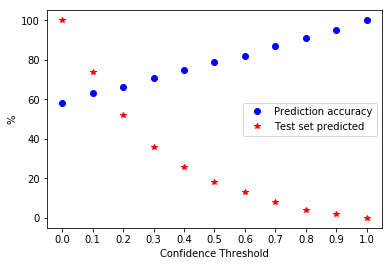

In [7]:
from ConfidenceMeasure import ct_studies

ct_studies(model, descriptors, labels)

In [8]:
model = 'classifier'
confidence_threshold = 0.4
model_confidence_threshold_list = [(model, confidence_threshold)]

confident_predictions, unpredicted_examples_ids = confidence_measure(model_confidence_threshold_list, ids, descriptors)

classifier (ct 0.40) confident predictions: 846 total

Examples that could not be determine: 2454 / 3300


##### Explore the results

In [9]:
# explore confident predictions: print the first 3 examples

result = confident_predictions[confidence_threshold]
print('CT      PREDICTION EXAMPLE')
if len(result) == 0: 
    print(confidence_threshold,' | ', '[()]') 
else: 
    print(confidence_threshold,' | ', result[:3])
    
# explore unpredicted examples: print the first 3 examples
print('\nUnpredicted examples: \n', unpredicted_examples_ids.values[:3])

CT      PREDICTION EXAMPLE
0.4  |  [('3D', 'example_11'), ('3D', 'example_14'), ('3D', 'example_15')]

Unpredicted examples: 
 ['example_0' 'example_1' 'example_2']


#### 5. Bin examples according to the confidence of their prediction 

In [10]:
model_file = 'classifier'
model_confidence_threshold_list = [(model_file, 1.0), (model_file, 0.9), 
                                   (model_file, 0.8), (model_file, 0.7), 
                                   (model_file, 0.6), (model_file, 0.5), 
                                   (model_file, 0.4), (model_file, 0.3), 
                                   (model_file, 0.1), (model_file, 0.0)]

confident_predictions, unpredicted_examples_ids = confidence_measure(model_confidence_threshold_list, ids, descriptors)

classifier (ct 1.00) confident predictions: 15 total
classifier (ct 0.90) confident predictions: 60 total
classifier (ct 0.80) confident predictions: 70 total
classifier (ct 0.70) confident predictions: 123 total
classifier (ct 0.60) confident predictions: 148 total
classifier (ct 0.50) confident predictions: 167 total
classifier (ct 0.40) confident predictions: 263 total
classifier (ct 0.30) confident predictions: 336 total
classifier (ct 0.10) confident predictions: 1244 total
classifier (ct 0.00) confident predictions: 874 total

All examples have been classified.


##### Explore the results

In [11]:
# explore confident predictions: print the first 3 examples

print('CT      PREDICTION EXAMPLE')
for confidence_threshold in confident_predictions:

    result = confident_predictions[confidence_threshold]
    
    if len(result) == 0: 
        print(confidence_threshold,' | ', '[()]') 
    else: 
        print(confidence_threshold,' | ', result[:3])

CT      PREDICTION EXAMPLE
1.0  |  [('3D', 'example_143'), ('3D', 'example_296'), ('3D', 'example_338')]
0.9  |  [('3D', 'example_14'), ('3D', 'example_15'), ('2D', 'example_26')]
0.8  |  [('3D', 'example_56'), ('3D', 'example_163'), ('0D', 'example_176')]
0.7  |  [('0D', 'example_38'), ('3D', 'example_92'), ('3D', 'example_114')]
0.6  |  [('3D', 'example_17'), ('0D', 'example_24'), ('3D', 'example_33')]
0.5  |  [('2D', 'example_16'), ('0D', 'example_18'), ('1D', 'example_29')]
0.4  |  [('3D', 'example_11'), ('1D', 'example_22'), ('0D', 'example_45')]
0.3  |  [('0D', 'example_12'), ('0D', 'example_19'), ('3D', 'example_25')]
0.1  |  [('0D', 'example_0'), ('3D', 'example_3'), ('0D', 'example_4')]
0.0  |  [('3D', 'example_1'), ('2D', 'example_2'), ('2D', 'example_5')]


#### Finally ...

We believe that this tool may have many more applications beyond the ones presented in this notebook. 

We anticipate the use of the confidence tool to create ensembles of classifieres, where the data patterns not find by the first methods, shall be captured by later ones. 

We also believe that the tool could find a useful application in self learning algorithms, specially in the automatic instance labeling.

We look forward to read you applications of the confidence measure tool and hope that this is a useful piece of code for you. 

Thanks for using our tool and please do not forget to cite us. :)